In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
import matplotlib.patches as patches
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline

# introduction to performance diagrams

Performance diagrams use a two-dimensional space of “probability of detection” ($POD=\frac{a}{a+c}$) and “success ratio” ($SR=\frac{b}{a+b}$) for visualizing forecast performance (Roebber 2009). These are also known as “precision-recall” diagrams in the fields of machine learning and information retrieval. These diagrams were developed originally by Cleverdon (1962) to evaluate information retrieval methods where “recall” (POD) and “relevancy” (equal to precision and success ratio, Brooks et al. 2024 provide a historical review of the plethora of names) values were jointly displayed, recall was plotted on the vertical axis in the same convention as used in the performance diagram of Roebber (2009). Roebber (2009) showed that frequency bias and critical success index (CSI; Donaldson et al. 1975) could be simultaneously displayed on performance diagrams, consistent with earlier work (Cleverdon and Keen 1966; Heine 1973) where contours of summary scores were displayed in the background of precision-recall diagrams. In this notebook, we introduce the performance diagram and show how to display any other score from the 2x2 contingency table in the background.

## 2x2 contingency table

Forecasts for a well-defined observed event can be evaluated by analyzing the elements of a 2x2 contingency table (see intro_2x2_table.ipynb for more details). A generic form of the 2x2 contingency table is shown below. The observed value for the $i^{th}$ case can be denoted as $obs=yes$ when the event was observed to occur,  $obs=no$ when the event did not occur. Forecasts could be provided in one of several forms: continuous (e.g., probabilistic), ordinal (e.g., slight/moderate/high), or binary (yes/no). Continuous and ordinal forecast values can be converted to binary forecasts via thresholding, $fcst=yes$ when the forecast value is greater than or equal to a threshold,  $fcst=no$ otherwise. The elements of the contingency table are simply the relative frequencies or proportions of each contingency (joint probabilities).

The “a” element of the contingency table provides the proportion of correct “yes” forecasts, often referred to as “true positives” or “hits”. The “b” element provides the proportion of incorrect “yes” forecasts, also known as “false positives” or “false alarms”. The “c” element provides the proportion of incorrect “no” forecasts, also denoted as “false negatives” or “missed events”. The “d” element provides the proportion of correct “no” forecasts, also called “true negatives” or “correct nulls”.

In [2]:
# generic 2x2 contingency table
pd.DataFrame(data=np.array([['a','b','a+b'],['c','d','c+d'],['a+c','b+d','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,a,b,a+b
fcst=no,c,d,c+d
col sum,a+c,b+d,1


## 2x2 contingency table in performance diagram (POD,SR) space

We can use the definitions of $POD=\frac{a}{a+c},SR=\frac{b}{a+b},$ along with the base rate $\bar x = a+c$ to express the elements of the 2x2 contingency table in terms of $POD$, $SR$, and $\bar x$, this will come in handy later:

In [3]:
# generic 2x2 contingency table in terms of POD, SR, and base rate
pd.DataFrame(data=np.array([[r'$\bar x (POD)$',r'$\bar x(\frac{POD}{SR}-POD)$',r'$\bar x\frac{POD}{SR}$'],[r'$\bar x (1-POD)$',r'$1-\bar x(\frac{POD}{SR}+1-POD)$',r'$1-\bar x\frac{POD}{SR}$'],[r'$\bar x$',r'$1-\bar x$','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,$\bar x (POD)$,$\bar x(\frac{POD}{SR}-POD)$,$\bar x\frac{POD}{SR}$
fcst=no,$\bar x (1-POD)$,$1-\bar x(\frac{POD}{SR}+1-POD)$,$1-\bar x\frac{POD}{SR}$
col sum,$\bar x$,$1-\bar x$,1


## generate synthetic forecasts and observations

The code blocks below show how to produce a performance diagram from arrays of forecast and observed values, synthetic data are generated using a beta distribution, following the example in generate_synth_data.ipynb.

In [4]:
# functions to generate synthetic forecasts and observations and compute the 2x2 contingency table

def synth_data(nn,xbar,fbar,sharp,rhoxf):
    # generate synthetic binary obs with base rate = xbar
    # generate synthetic forecasts [continuous beta-distributed probability-like]
    # generate synthetic forecasts [binary with mean forecast = fbar]
    # rhoxf controls the correlation of the bivariate normal that is used to generate obs and fcst-beta
    # sharp controls the normalized sharpness in determining the beta distribution parameters of the fcsts
    cov = np.array([[1.,rhoxf ], [rhoxf,1.]])
    pts = rng.multivariate_normal([0., 0.], cov, size=nn)
    obs_bin=np.zeros_like(pts[:,0])
    xthresh=norm.ppf(1-xbar,0.,1.)
    obs_bin[pts[:,0]>=xthresh]=1.
    sx21=xbar*(1.-xbar)
    sf21=sharp*sx21
    nu1=fbar*(1-fbar)/sf21-1.
    alpha1=fbar*nu1
    beta1=(1.-fbar)*nu1
    fcst_beta=beta.ppf(norm.cdf(pts[:,1],0.,1.), alpha1,beta1)
    fthresh=np.quantile(fcst_beta,1.-fbar)
    fcst_bin=fcst_beta>=fthresh
    return obs_bin,fcst_beta,fcst_bin

def calc_2x2_table(fcst,obs,thresholds):
    # assuming fcst and obs are of the same length, fcst are continuous and obs are binary
    # loop over thresholds and find elements of 2x2 contingency table for each
    # return these in a pandas dataframe
    nthresh=len(thresholds)
    aa=np.full(nthresh,np.nan)
    bb=np.full(nthresh,np.nan)
    cc=np.full(nthresh,np.nan)
    dd=np.full(nthresh,np.nan)
    for j in np.arange(nthresh):
        fthresh=thresholds[j]
        fcst_bin=fcst>=fthresh
        nn=float(len(obs))
        aa[j]=np.sum(obs*fcst_bin)/nn
        bb[j]=np.sum((1.-obs)*fcst_bin)/nn
        cc[j]=np.sum(obs*(1.-fcst_bin))/nn
        dd[j]=np.sum((1.-obs)*(1.-fcst_bin))/nn
    df=pd.DataFrame(data=np.array([thresholds,aa,bb,cc,dd]).T,columns=['thresh','a','b','c','d'])
    return df

def pod(a,b,c,d):
    return a/(a+c)

def sr(a,b,c,d):
    return a/(a+b)

In [5]:
# these values will generate a large sample of synthetic fcst/obs data with d' approximately 1.2
nn=100000
xbar=0.1
fbar=0.1
rhoxf=0.55
ratio=0.2

obs_pts,fcst_pts,fcst_bin=synth_data(nn,xbar,fbar,ratio,rhoxf)

# set up array of thresholds going from zero to slightly above the max forecast value
# this will produce PODs that vary from 1 to 0, POFDs that vary from 1 to 0
threshs=np.quantile(fcst_pts,np.linspace(0.001,0.999,99))
threshs=np.insert(threshs,0,0.)
threshs=np.append(threshs,np.max(fcst_pts)*1.01)

# generate arrays of 2x2 contingency table elements corresponding with these thresholds
df = calc_2x2_table(fcst_pts,obs_pts,threshs)
df['POD']=df.a/(df.a+df.c)
df['SR']=df.a/(df.a+df.b)
df

,thresh,a,b,c,d,POD,SR
0,0.000000e+00,0.10033,0.89967,0.00000,0.00000,1.000000,0.100330
1,8.965323e-09,0.10033,0.89867,0.00000,0.00100,1.000000,0.100430
2,3.309855e-06,0.10033,0.88848,0.00000,0.01119,1.000000,0.101465
3,1.601465e-05,0.10030,0.87833,0.00003,0.02134,0.999701,0.102490
4,4.092475e-05,0.10028,0.86816,0.00005,0.03151,0.999502,0.103548
...,...,...,...,...,...,...,...
96,4.599398e-01,0.01480,0.01676,0.08553,0.88291,0.147513,0.468948
97,5.119441e-01,0.01090,0.01047,0.08943,0.88920,0.108641,0.510061
98,5.876057e-01,0.00639,0.00480,0.09394,0.89487,0.063690,0.571046
99,7.740083e-01,0.00076,0.00024,0.09957,0.89943,0.007575,0.760000


## performance diagram

Given a set of observations and paired forecast values, we can specify a forecast threshold and compute the elements of the resulting 2x2 contingency table associated with that threshold. A performance curve is produced by systematically varying this threshold and plotting $POD$ vs $SR$. An example is provided below.

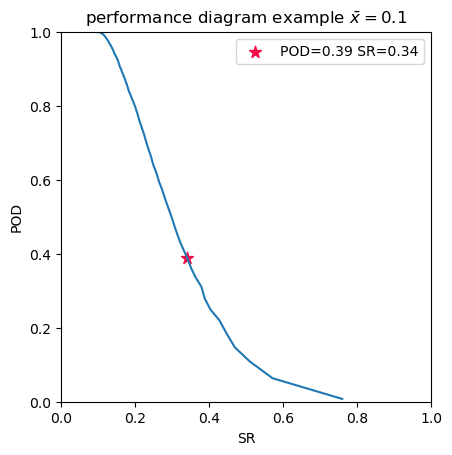

In [6]:
# example performance diagram, full curve and single point

fig,ax = plt.subplots()

xbar1=np.mean(obs_pts)

pod1=df.a/(df.a+df.c)
sr1=df.a/(df.a+df.b)
pod_pt=np.round(pod1[np.argmax(pod1<0.4)],2)
sr_pt=np.round(sr1[np.argmax(pod1<0.4)],2)
lab1=f'POD={np.round(pod_pt,2)} SR={np.round(sr_pt,2)}'

ax.scatter(sr_pt,pod_pt,marker='*',s=80,color='#f10c45',label=lab1)
ax.plot(sr1,pod1)
ax.set_xlabel('SR')
ax.set_ylabel('POD')
ax.set_title('performance diagram example '+r'$\bar x =$'+f'{np.round(xbar1,2)}')
ax.set_aspect('equal')
ax.set_xlim(0.,1.)
ax.set_ylim(0.,1.)
ax.legend()

This ROC curve displays the typical connection between $POD$ and $SR$. Consider starting with a constant "yes" forecast $(a+b=1)$, which corresponds with the "top" of the performance curve. In that case, all of the observed events will be "hit" and $POD=1$, but the proportion of "yes" forecasts that are correct ("success ratio") will be equal to the base rate $SR=\bar x$. As the forecast threshold increases (and the overall proportion of "yes" forecasts decreases), more and more of the observed events will be missed, the proportion of observed events that were correctly forecast ($POD$) will decrease, while the proportion of correct "yes" forecasts will likely increase (assuming the forecast system has some skill). $POD$ and $SR$ tend to change "in opposition". 

## zero skill reference

It is often helpful to know how the performance of a forecast system compares to a "reference" forecast that we consider having no $skill$ (defined by Murphy 1993 as relative accuracy). The choice of reference forecast is an important issue in determining a quantitative measure of skill, several studies (e.g., Murphy 1988; Mason 2004; Hamill and Juras 2006) have noted issues with using single-valued reference forecasts to quantify skill, particularly when the verification dataset is aggregated from pooled subsets that have different base rates or forecast variances. Consistent with previous skill score derivations (e.g., Gilbert 1884; Peirce 1884; Doolittle 1885; Heidke 1925; Doswell et al. 1990; Schaefer 1990), we can define the reference forecast as that expected from random chance (intro_2x2_table.ipynb provides additional detail on derivation of the random 2x2 contingency table), obtained from the verification data sample:

$POD_{random} = \frac{a_{random}}{a+c} = \frac{(a+b)(a+c)}{a+c} = a + b = \bar f$

$SR_{random} = \frac{a_{random}}{a+b} = \frac{(a+b)(a+c)}{a+b} = a + c = \bar x$

The random forecast performance can be defined across the full range of forecast thresholds, from "all no" $\bar f = 0$ to "all yes" $\bar f = 1$. Therefore, we would expect a random forecast to follow the $SR_{random}=\bar x$ line on a performance diagram across the full range of $POD_{random} = 0 \rightarrow 1$. This line is often provided for visual reference.

In the example below, the array of synthetic forecasts is randomly permuted and a new set of 2x2 contingency table values are calculated from the same thresholds that we used to demonstrate the performance of the synthetic forecasts. We find that $POD$ varies from 0 to 1 and $SR$ remains near $\bar x = 0.1$ across all thresholds, this randomly permuted forecast is compared to the synthetic (skillful) forecast below.


In [7]:
# randomly shuffle the forecast array and generate the corresponding 2x2 contingency table
rng=np.random.default_rng()
fcst_rand=rng.permutation(fcst_pts)
df_perm = calc_2x2_table(fcst_rand,obs_pts,threshs)
df_perm['POD']=df_perm.a/(df_perm.a+df_perm.c)
df_perm['SR']=df_perm.a/(df_perm.a+df_perm.b)
df_perm

,thresh,a,b,c,d,POD,SR
0,0.000000e+00,0.10033,0.89967,0.00000,0.00000,1.000000,0.100330
1,8.965323e-09,0.10024,0.89876,0.00009,0.00091,0.999103,0.100340
2,3.309855e-06,0.09930,0.88951,0.00103,0.01016,0.989734,0.100424
3,1.601465e-05,0.09826,0.88037,0.00207,0.01930,0.979368,0.100406
4,4.092475e-05,0.09717,0.87127,0.00316,0.02840,0.968504,0.100337
...,...,...,...,...,...,...,...
96,4.599398e-01,0.00284,0.02872,0.09749,0.87095,0.028307,0.089987
97,5.119441e-01,0.00191,0.01946,0.09842,0.88021,0.019037,0.089378
98,5.876057e-01,0.00097,0.01022,0.09936,0.88945,0.009668,0.086685
99,7.740083e-01,0.00007,0.00093,0.10026,0.89874,0.000698,0.070000


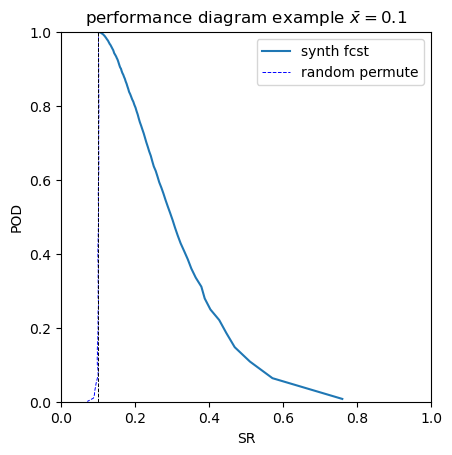

In [8]:
# example performance diagram, compare forecast to random permutation, include no-skill line

fig,ax = plt.subplots()

xbar1=np.mean(obs_pts)

pod1=df.a/(df.a+df.c)
sr1=df.a/(df.a+df.b)
pod_pt=np.round(pod1[np.argmax(pod1<0.4)],2)
sr_pt=np.round(sr1[np.argmax(pod1<0.4)],2)
lab1=f'POD={np.round(pod_pt,2)} SR={np.round(sr_pt,2)}'

ax.plot(sr1,pod1,label='synth fcst')
ax.plot(df_perm.SR,df_perm.POD,'b--',lw=0.7,label='random permute')

# zero skill line
ax.plot([xbar1,xbar1],[0,1],'k--',lw=0.7)
ax.set_xlabel('SR')
ax.set_ylabel('POD')
ax.set_title('performance diagram example '+r'$\bar x =$'+f'{np.round(xbar1,2)}')
ax.set_aspect('equal')
ax.set_xlim(0.,1.)
ax.set_ylim(0.,1.)
ax.legend()

## add other scores in the background

In this 2-D $(POD,SR)$ space, we can define all four elements of the 2x2 contingency table for a specific base rate (see above). This allows us to calculate different scores and plot them in the background of the diagram. Roebber (2009) placed CSI and bias in the background of his performance diagrams, which has been widely adopted. Since $bias=\frac{POD}{SR}$ is simply $\frac{y}{x}=tan(\theta)$ in this space, there is a geometric interpretion of bias as the tangent of the angle between a point in $(POD,SR)$ space and the x-axis. Points above the main diagonal have an overforecasting $bias\gt 1$, while points below the main diagonal have an underforecasting $bias\lt 1$. 

Since many scores depend on the base rate in this 2-D space, it can be informative to see how the behavior of scores change with different base rates. Scores that can be expressed in terms of $POD$ and $SR$ alone (such as $CSI=\frac{a}{a+b+c}$ and $F_1=\frac{2a}{2a+b+c}$) will be invariant to base rate in this space.  In the example below, $CSI$ is shown in the background as a color fill and $bias$ contours are shown as dashed black lines.

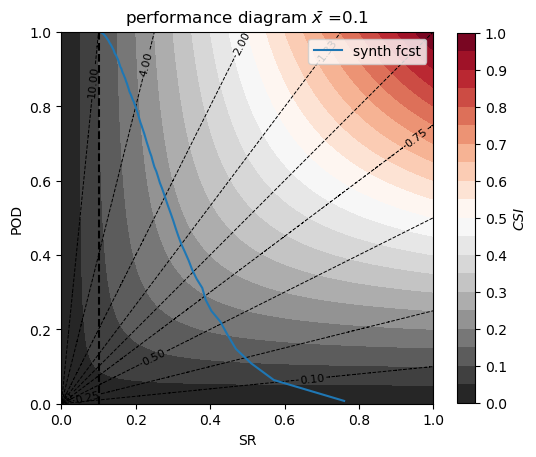

In [9]:
# plot background scores on performance diagrams

# some functions to assist with score calculation
def csi(a,b,c,d):
    return a/(a+b+c)

def bias(a,b,c,d):
    return (a+b)/(a+c)

# need to know the base rate in order to find the 2x2 contingency table elements in (POD,SR) space
xbar=0.1

fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, SR to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
sr_x=np.arange(0.001,1.0,0.001)
sr_perf,pod_perf=np.meshgrid(sr_x,pod_y)

# 2x2 contingency elements in 2-D POD,SR space
aa_2d=xbar*pod_perf
bb_2d=xbar*(pod_perf/sr_perf-pod_perf)
cc_2d=xbar*(1.-pod_perf)
dd_2d=1.-xbar*(pod_perf/sr_perf+1.-pod_perf)

# labels and ticks for background score colorbar
label1=r'$CSI$'
extend1='neither'
d_lvls=np.linspace(0.,1.,21)
d_ticks=np.linspace(0.,1.,11)

# plot diagram with background score colorfill and bias contours
cs0=axs.contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)

sc1=axs.contourf(sr_x,pod_y,csi(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.8,label=label1,ax=axs,ticks=d_ticks)

#zero skill line - vertical at SR = base rate
axs.plot([xbar,xbar],[0,1],'k--')

axs.set_aspect('equal')
axs.set_xlim(0.,1.)
axs.set_ylim(0.,1.)
axs.set_xlabel('SR')
axs.set_ylabel('POD')
axs.set_title(r'performance diagram $\bar x$ ='+f'{xbar}')

# plot example performance curve

axs.plot(df.SR,df.POD,label='synth fcst')
axs.legend()



## masking out the 'no-skill' region

In this example above, the background scores were displayed in the full 2-D $(POD,SR)$ space, although the left-hand portion ($SR\lt \bar x$) of the diagram is a region where the forecast would be worse than random (negative skill). It can be helpful to mask out that region in the diagram to clearly indicate where the 'no-skill' region is located. In the code example that follows, a matplotlib "patch" is used to plot a hatched pattern in the no-skill region and the 2x2 contingency table elements are set to np.nan to remove that area from any score plotting/calculation. $d'$ is shown in the background of the example below since it will be zero for a random forecast $(POD=POFD)$ and can be helpful in understanding the behavior of forecast systems (e.g., Brooks (2004)).

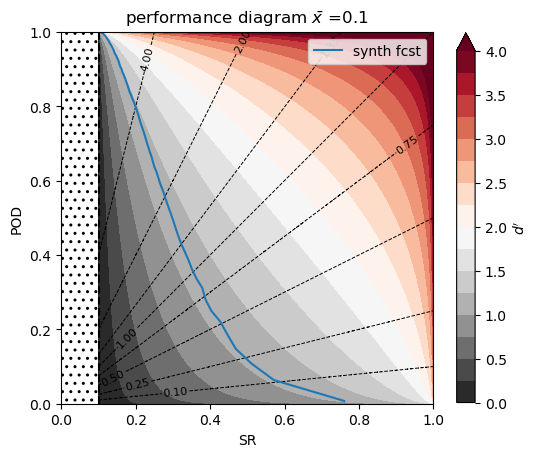

In [10]:
# performance diagram - mask out "no skill" region

# some functions to assist with score calculation
def dprime(a,b,c,d):
    return norm.ppf(a/(a+c))-norm.ppf(b/(b+d))

def bias(a,b,c,d):
    return (a+b)/(a+c)

# 2x2 contingency elements depend on base rate
xbar=0.1

# need to know the base rate in order to find the 2x2 contingency table elements in (POD,SR) space
xbar=0.1

fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, SR to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
sr_x=np.arange(0.001,1.0,0.001)
sr_perf,pod_perf=np.meshgrid(sr_x,pod_y)

# 2x2 contingency elements in 2-D POD,SR space
aa_2d=xbar*pod_perf
bb_2d=xbar*(pod_perf/sr_perf-pod_perf)
cc_2d=xbar*(1.-pod_perf)
dd_2d=1.-xbar*(pod_perf/sr_perf+1.-pod_perf)

# set no skill region to nan
aa_2d[sr_perf<xbar]=np.nan
bb_2d[sr_perf<xbar]=np.nan
cc_2d[sr_perf<xbar]=np.nan
dd_2d[sr_perf<xbar]=np.nan

# labels and ticks for background score colorbar
label1=r"$d'$"
extend1='max'
d_lvls=np.linspace(0.,4.,17)
d_ticks=np.linspace(0.,4.,9)

# plot diagram with background score colorfill and bias contours
cs0=axs.contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)

sc1=axs.contourf(sr_x,pod_y,dprime(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.8,label=label1,ax=axs,ticks=d_ticks)

#zero skill line - vertical at SR = base rate
axs.plot([xbar,xbar],[0,1],color='k',linestyle='dashed')

axs.set_aspect('equal')
axs.set_xlim(0.,1.)
axs.set_ylim(0.,1.)
axs.set_xlabel('SR')
axs.set_ylabel('POD')
axs.set_title(r'performance diagram $\bar x$ ='+f'{xbar}')

# get data you will need to create a "background patch" to your plot
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xy = (xmin+0.001,ymin+0.001)
width = xmax - xmin - 0.002
height = ymax - ymin - 0.002
# create the patch and place it in the back of countourf (zorder!)
p = patches.Rectangle(xy, width, height, hatch='..', linewidth=0,fill=None, zorder=-10)
axs.add_patch(p)

# plot example performance curve

axs.plot(df.SR,df.POD,label='synth fcst')
axs.legend()


## unachievable region

There is also a portion of the performance diagram is that impossible to reach, called the "unachievable region" by Boyd et al. (2012). For example, it is impossible to reach the upper left corner $(POD=SR=1)$ since an "all yes" forecast results in $POD=1$ and $SR=\bar x$. We can derive an expression for the outline of this region for a specific base rate by finding the $SR$ value associated with setting $d$ element of the 2x2 contingency table to zero and writing that in terms of $POD$ and $\bar x$ ($d$ cannot be negative). This region will always be in the "no-skill" region $SR\lt \bar x$ and will vary with $POD$ and $\bar x$:
\begin{equation}
SR_{min}=\frac{\bar x (POD)}{1+\bar x (POD-1)}
\end{equation}

The code below plots two different hatched areas to deliniate the "no skill" region (dotted) from the "unachievable region" (cross hatch).

Boyd, K., V. S. Costa, J. Davis, and D. Page, 2012: Unachievable region in precision-recall space and its effect on empirical evaluation. https://arxiv.org/abs/1206.4667

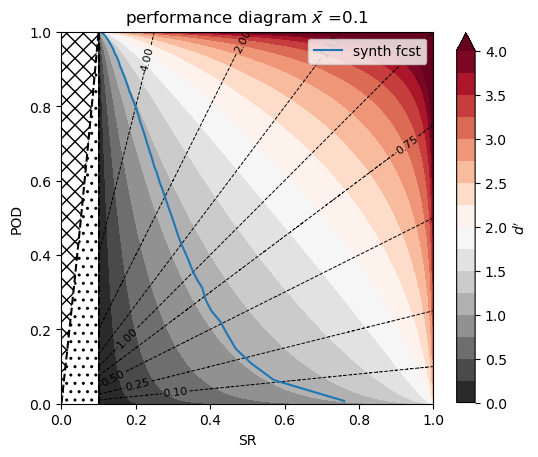

In [11]:
# performance diagram - mask out "no skill" region

# some functions to assist with score calculation
def dprime(a,b,c,d):
    return norm.ppf(a/(a+c))-norm.ppf(b/(b+d))

def bias(a,b,c,d):
    return (a+b)/(a+c)

# 2x2 contingency elements depend on base rate
xbar=0.1

fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, SR to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
sr_x=np.arange(0.001,1.0,0.001)
sr_perf,pod_perf=np.meshgrid(sr_x,pod_y)

# 2x2 contingency elements in 2-D POD,SR space
aa_2d=xbar*pod_perf
bb_2d=xbar*(pod_perf/sr_perf-pod_perf)
cc_2d=xbar*(1.-pod_perf)
dd_2d=1.-xbar*(pod_perf/sr_perf+1.-pod_perf)

# set no skill region to nan
aa_2d[sr_perf<xbar]=np.nan
bb_2d[sr_perf<xbar]=np.nan
cc_2d[sr_perf<xbar]=np.nan
dd_2d[sr_perf<xbar]=np.nan

# labels and ticks for background score colorbar
label1=r"$d'$"
extend1='max'
d_lvls=np.linspace(0.,4.,17)
d_ticks=np.linspace(0.,4.,9)

# plot diagram with background score colorfill and bias contours
cs0=axs.contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)

sc1=axs.contourf(sr_x,pod_y,dprime(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.8,label=label1,ax=axs,ticks=d_ticks)

#zero skill line - vertical at SR = base rate
axs.plot([xbar,xbar],[0,1],color='k',linestyle='dashed')

axs.set_aspect('equal')
axs.set_xlim(0.,1.)
axs.set_ylim(0.,1.)
axs.set_xlabel('SR')
axs.set_ylabel('POD')
axs.set_title(r'performance diagram $\bar x$ ='+f'{xbar}')

# get data you will need to create a "background patch" to your plot
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xy = (xmin+0.001,ymin+0.001)
width = xmax - xmin - 0.002
height = ymax - ymin - 0.002

# minimum possible SR
sr_min=xbar*pod_y/(1.-xbar+xbar*pod_y)
axs.plot(sr_min,pod_y,'k--')
# create patches and place in the background
p = patches.Polygon(np.array([np.append(sr_min,[0.,0.]),np.append(pod_y,[1.,0.])]).T, hatch='xx', linewidth=0,fill=None, zorder=1)
axs.add_patch(p)
p2 = patches.Polygon(np.array([np.append(sr_min,[xbar,0.]),np.append(pod_y,[0.,0.])]).T, hatch='..', linewidth=0,fill=None, zorder=-5)
axs.add_patch(p2)

# plot example performance curve

axs.plot(df.SR,df.POD,label='synth fcst')
axs.legend()


## area under the curve (AUCPR)

One way to summarize the performance of a forecast system is to calculate the area under the curve ($AUCPR$ called $AUPRC$ in the machine-learning community) on a performance diagram. Since a random no-skill forecast ($SR=\bar x$) will produce $AUCPR_{random}=\bar x$, Flora et al. (2021) and Miller et al. (2022) modified the area under the curve calculation to remove the unskillful region (normalized area under performance diagram curve).

The code below shows how to use the trapezoidal rule (numpy.trapz) to estimate this, along with a function from scikit-learn (sklearn.metrics.average_precision_score).

Flora, M. L., C. K. Potvin, P. S. Skinner, S. Handler, and A. McGovern, 2021: Using Machine Learning to Generate Storm-Scale Probabilistic Guidance of Severe Weather Hazards in the Warn-on-Forecast System. Mon. Wea. Rev., 149, 1535–1557, https://doi.org/10.1175/MWR-D-20-0194.1. 

Miller, W. J. S., and Coauthors, 2022: Exploring the Usefulness of Downscaling Free Forecasts from the Warn-on-Forecast System. Wea. Forecasting, 37, 181–203, https://doi.org/10.1175/WAF-D-21-0079.1.


In [12]:
from sklearn import metrics

# APS from sklearn metrics
print('sklearn APS = ',np.round(metrics.average_precision_score(obs_pts,fcst_pts),3))

# area under curve from numpy trapz, flipping arrays since pod,sr go from 1 to 0 in this example
print('trapz area under curve = ',np.round(np.trapz(np.flipud(df.dropna().SR),np.flipud(df.dropna().POD)),3))

sklearn APS =  0.323
trapz area under curve =  0.318


## sensitivity to base rate

Typically, information regarding a "no-skill" reference forecast is not provided, making determination of "skill" (accuracy relative to a random/no-skill baseline) very difficult to determine. The "no-skill" region will shift to the right as the base rate increases, for very common events it may even take up the majority of the $(POD,SR)$ space.

To demonstrate this, you can modify the base rate in the code blocks to see how various background scores, 'no-skill', and 'unachievable' regions vary with $\bar x$. An example of a very common event ($\bar x \approx 0.75$) below shows an operational NWP model's performance in predicting $CAPE\ge $250 J/kg at 00 UTC in the warm season and southern part of the U.S. The performance diagram on the left shows this on a "standard" performance diagram with $CSI$ and $bias$ in the background without showing the 'no-skill' region, with the point near the upper-right corner it appears to be a nearly perfect forecast system. On the right, this is plotted with the 'no-skill' region clearly indicated, showing the forecast as skillful, but perhaps not as impressive as it looked without knowledge of the 'no-skill' baseline.

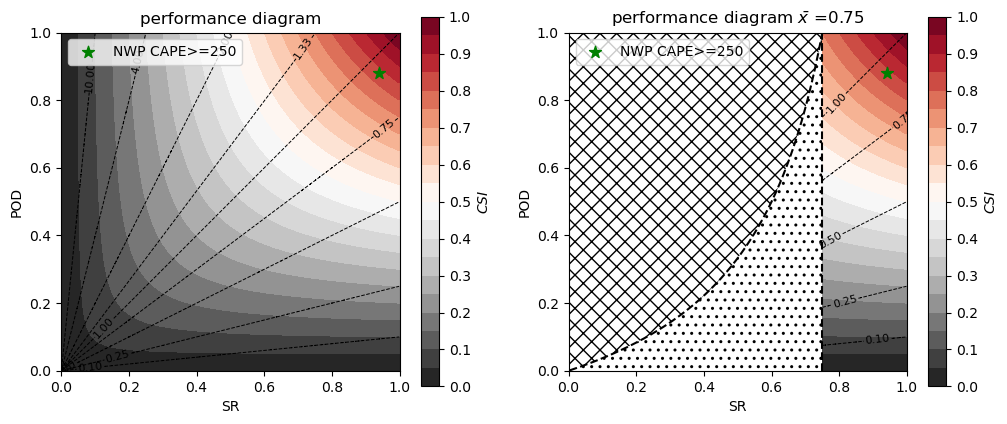

In [13]:
# performance diagram - very common event
# example data for NWP model predicting CAPE >= 250 J/kg at 00 UTC in the south/warm season
xbar=0.75
pod_cape=0.88
sr_cape=0.94

# labels and ticks for background score colorbar
label1=r"$CSI$"
extend1='neither'
d_lvls=np.linspace(0.,1.,21)
d_ticks=np.linspace(0.,1.,11)

# 2x2 contingency elements depend on base rate

fig, axs = plt.subplots(1,2,figsize=(12,6))

# arrays hold 2d fields of POD, SR to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
sr_x=np.arange(0.001,1.0,0.001)
sr_perf,pod_perf=np.meshgrid(sr_x,pod_y)

# 2x2 contingency elements in 2-D POD,SR space
aa_2d=xbar*pod_perf
bb_2d=xbar*(pod_perf/sr_perf-pod_perf)
cc_2d=xbar*(1.-pod_perf)
dd_2d=1.-xbar*(pod_perf/sr_perf+1.-pod_perf)

# plot "traditional" diagram with CSI colorfill and bias contours across the full domain
cs0=axs[0].contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs[0].clabel(cs0, cs0.levels, inline=True, fontsize=8)

sc1=axs[0].contourf(sr_x,pod_y,csi(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.8,label=label1,ax=axs[0],ticks=d_ticks)
axs[0].set_aspect('equal')
axs[0].set_xlim(0.,1.)
axs[0].set_ylim(0.,1.)
axs[0].set_xlabel('SR')
axs[0].set_ylabel('POD')
axs[0].set_title(r'performance diagram')

axs[0].scatter(sr_cape,pod_cape,label="NWP CAPE>=250",s=80,marker='*',color='green')
axs[0].legend(loc='upper left')


# include no-skill region
# set no skill region to nan
aa_2d[sr_perf<xbar]=np.nan
bb_2d[sr_perf<xbar]=np.nan
cc_2d[sr_perf<xbar]=np.nan
dd_2d[sr_perf<xbar]=np.nan


# plot diagram with background score colorfill and bias contours
cs0=axs[1].contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs[1].clabel(cs0, cs0.levels, inline=True, fontsize=8)

sc1=axs[1].contourf(sr_x,pod_y,csi(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.8,label=label1,ax=axs[1],ticks=d_ticks)

#zero skill line - vertical at SR = base rate
axs[1].plot([xbar,xbar],[0,1],color='k',linestyle='dashed')

axs[1].set_aspect('equal')
axs[1].set_xlim(0.,1.)
axs[1].set_ylim(0.,1.)
axs[1].set_xlabel('SR')
axs[1].set_ylabel('POD')
axs[1].set_title(r'performance diagram $\bar x$ ='+f'{xbar}')

# get data you will need to create a "background patch" to your plot
xmin, xmax = axs[1].get_xlim()
ymin, ymax = axs[1].get_ylim()
xy = (xmin+0.001,ymin+0.001)
width = xmax - xmin - 0.002
height = ymax - ymin - 0.002

# minimum possible SR
sr_min=xbar*pod_y/(1.-xbar+xbar*pod_y)
axs[1].plot(sr_min,pod_y,'k--')
# create patches and place in the background
p = patches.Polygon(np.array([np.append(sr_min,[0.,0.]),np.append(pod_y,[1.,0.])]).T, hatch='xx', linewidth=0,fill=None, zorder=1)
axs[1].add_patch(p)
p2 = patches.Polygon(np.array([np.append(sr_min,[xbar,0.]),np.append(pod_y,[0.,0.])]).T, hatch='..', linewidth=0,fill=None, zorder=-5)
axs[1].add_patch(p2)

# plot example performance curve

axs[1].scatter(sr_cape,pod_cape,label="NWP CAPE>=250",marker='*',s=80,color='green')
axs[1].legend(loc='upper left')


## mixing base rates on the same performance diagram
### is not recommended

Given the strong dependence of the four elements of the 2x2 contingency table to base rate in $(POD,SR)$ space, plots of $(POD,SR)$ across different observed events with different base rates is not recommended (such as traditional QPF verification where multiple precipitation thresholds are displayed in the same diagram). An example is shown in the code blocks below. In these, the performance "curves" are created by varying both the forecast and observed precipitation threshold, producing drastically different base rates for each point on the curve. This is not the same as the method described previously, where a well-defined observed event is selected (or a single threshold for a observed variable such as precipitation) and the forecast threshold is systematically varied from "all no" to "all yes" (same approach as ROC curves). This can be very confusing since both methods produce "curves" in $(POD,SR)$ space.

The first performance diagram below is a "traditional" example with $CSI$ and $bias$ in the background (covering the entire 2-D $POD,SR$ space) with the performance of different precipitation thresholds (different markers) connected by a line on the chart. The base rates differ significantly across these thresholds ($\bar x \approx 0.3$ to $\bar x \approx 0.01$), although that information is not available to the viewer. While we can quickly determine the variations in $CSI$ and $bias$ for these different thresholds, displaying the results in this way makes it impossible to determine the "skill" (relative to a random forecast) of any particular threshold. In addition, the performance of higher precipitation thresholds is typically described as "less skillful" than lower thresholds, since $CSI$ decreases with threshold and those points get further away from a perfect forecast (upper-right corner).

The second set of performance diagrams below plot each precipitation threshold separately, with the appropriate 'no-skill' and 'unachievable' regions along with 2x2 contingency table scores in the background corresponding with the base rates at each threshold. In this case, $d'=Z(POD)-Z(POFD)$ is displayed in the background, which is a measure that provides information regarding the discrimination ability of the forecast (ability to separate observed events from non-events, see intro_ROC_diagram.ipynb). In this example, although $CSI$ decreases as precipitation threshold increases, $d'$ actually increases with precipitation threshold, going from $d'\approx 1.3$ at the 0.01" threshold up to $d'\approx 2.2$ at the 1" threshold, indicating the discrimination ability of this forecast system increases with increasing precipitation threshold.

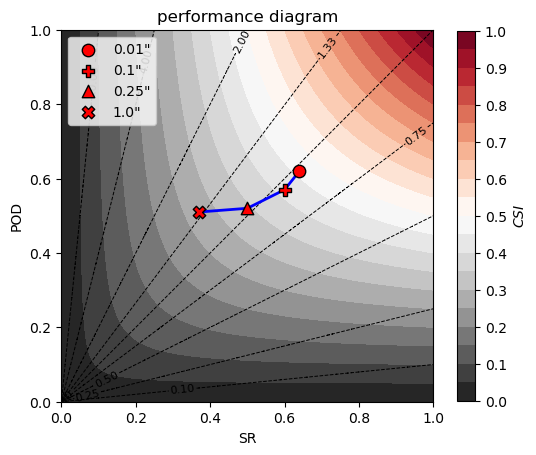

In [14]:
# performance diagram - mixing base rates
# example data for NWP model QPF verification

markers=['o','P','^','X']
pod_qpf=np.array([0.62,0.57,0.52,0.51])
sr_qpf=np.array([0.64,0.60,0.50,0.37])
xbar_qpf=np.array([0.31,0.18,0.096,0.017])
thr1=np.array([0.01,0.1,0.25,1.0])

# choose a base rate to calculate contingency table elements, will only be valid for this base rate
xbar=xbar_qpf[0]

# labels and ticks for background score colorbar
label1=r"$CSI$"
extend1='neither'
d_lvls=np.linspace(0.,1.,21)
d_ticks=np.linspace(0.,1.,11)

# 2x2 contingency elements depend on base rate

fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, SR to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
sr_x=np.arange(0.001,1.0,0.001)
sr_perf,pod_perf=np.meshgrid(sr_x,pod_y)

# 2x2 contingency elements in 2-D POD,SR space
aa_2d=xbar*pod_perf
bb_2d=xbar*(pod_perf/sr_perf-pod_perf)
cc_2d=xbar*(1.-pod_perf)
dd_2d=1.-xbar*(pod_perf/sr_perf+1.-pod_perf)

# plot "traditional" diagram with CSI colorfill and bias contours across the full domain
cs0=axs.contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)

sc1=axs.contourf(sr_x,pod_y,csi(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.8,label=label1,ax=axs,ticks=d_ticks)
axs.set_aspect('equal')
axs.set_xlim(0.,1.)
axs.set_ylim(0.,1.)
axs.set_xlabel('SR')
axs.set_ylabel('POD')
axs.set_title(r'performance diagram')
axs.plot(sr_qpf,pod_qpf,c='b',lw=2,zorder=5)
for ij in np.arange(len(thr1)):
    thresh=thr1[ij]
    axs.scatter(sr_qpf[ij],pod_qpf[ij],facecolor='r',edgecolor='k',s=80,marker=markers[ij],label=f'{thresh}"',zorder=6)
axs.legend(loc='upper left')

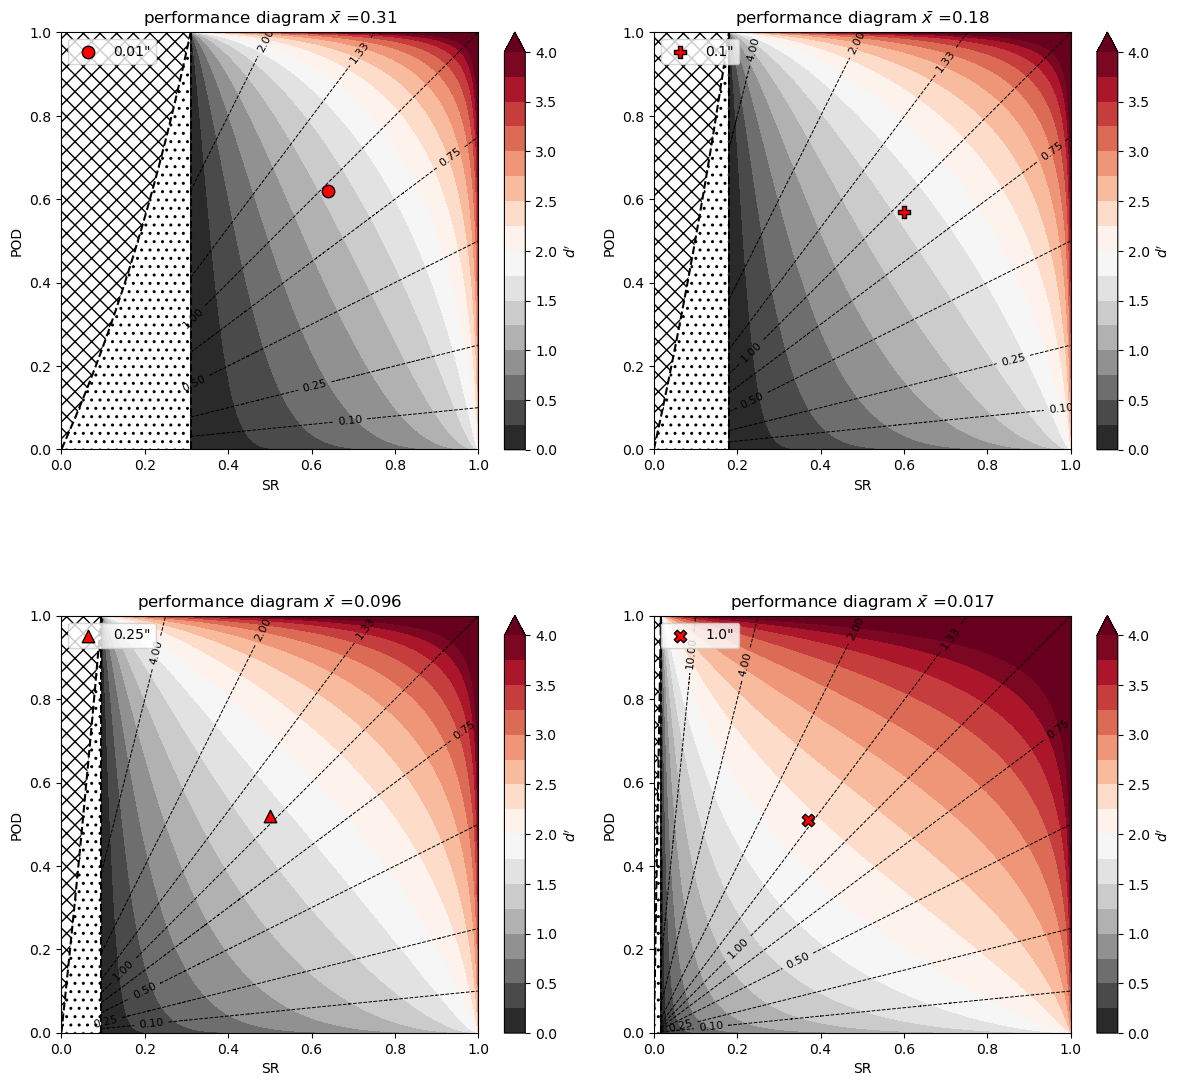

In [15]:
# performance diagram - mixing base rates
# example data for NWP model QPF verificatoin

def phi(a,b,c,d):
    return (a*d-b*c)/np.sqrt((a+c)*(c+d)*(a+b)*(b+d))
    
markers=['o','P','^','X']
pod_qpf=np.array([0.62,0.57,0.52,0.51])
sr_qpf=np.array([0.64,0.60,0.50,0.37])
xbar_qpf=np.array([0.31,0.18,0.096,0.017])
thr1=np.array([0.01,0.1,0.25,1.0])

# labels and ticks for background score colorbar
label1=r"$d'$"
extend1='max'
d_lvls=np.linspace(0.,4.,17)
d_ticks=np.linspace(0.,4.,9)

# 2x2 contingency elements depend on base rate

fig, ax = plt.subplots(2,2,figsize=(12,12))
axs=ax.flat

for ij in np.arange(len(thr1)):
    
    xbar=xbar_qpf[ij]
    # arrays hold 2d fields of POD, SR to allow for calculation of scores in background of plots
    pod_y=np.arange(0.001,1.0,0.001)
    sr_x=np.arange(0.001,1.0,0.001)
    sr_perf,pod_perf=np.meshgrid(sr_x,pod_y)
    
    # 2x2 contingency elements in 2-D POD,SR space
    aa_2d=xbar*pod_perf
    bb_2d=xbar*(pod_perf/sr_perf-pod_perf)
    cc_2d=xbar*(1.-pod_perf)
    dd_2d=1.-xbar*(pod_perf/sr_perf+1.-pod_perf)
    
    # include no-skill region
    # set no skill region to nan
    aa_2d[sr_perf<xbar]=np.nan
    bb_2d[sr_perf<xbar]=np.nan
    cc_2d[sr_perf<xbar]=np.nan
    dd_2d[sr_perf<xbar]=np.nan
    
    
    # plot diagram with background score colorfill and bias contours
    cs0=axs[ij].contour(sr_x,pod_y,bias(aa_2d,bb_2d,cc_2d,dd_2d),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
    axs[ij].clabel(cs0, cs0.levels, inline=True, fontsize=8)
    
    sc1=axs[ij].contourf(sr_x,pod_y,dprime(aa_2d,bb_2d,cc_2d,dd_2d),levels=d_lvls,cmap='RdGy_r',extend=extend1)
    plt.colorbar(sc1,orientation='vertical',shrink=0.715,label=label1,ax=axs[ij],ticks=d_ticks)
    
    #zero skill line - vertical at SR = base rate
    axs[ij].plot([xbar,xbar],[0,1],color='k',linestyle='dashed')
    
    axs[ij].set_aspect('equal')
    axs[ij].set_xlim(0.,1.)
    axs[ij].set_ylim(0.,1.)
    axs[ij].set_xlabel('SR')
    axs[ij].set_ylabel('POD')
    axs[ij].set_title(r'performance diagram $\bar x$ ='+f'{np.round(xbar,3)}')
    
    # get data you will need to create a "background patch" to your plot
    xmin, xmax = axs[ij].get_xlim()
    ymin, ymax = axs[ij].get_ylim()
    xy = (xmin+0.001,ymin+0.001)
    width = xmax - xmin - 0.002
    height = ymax - ymin - 0.002
    
    # minimum possible SR
    sr_min=xbar*pod_y/(1.-xbar+xbar*pod_y)
    axs[ij].plot(sr_min,pod_y,'k--')
    # create patches and place in the background
    p = patches.Polygon(np.array([np.append(sr_min,[0.,0.]),np.append(pod_y,[1.,0.])]).T, hatch='xx', linewidth=0,fill=None, zorder=1)
    axs[ij].add_patch(p)
    p2 = patches.Polygon(np.array([np.append(sr_min,[xbar,0.]),np.append(pod_y,[0.,0.])]).T, hatch='..', linewidth=0,fill=None, zorder=-5)
    axs[ij].add_patch(p2)
    
    # plot example performance curve
    
    thresh=thr1[ij]
    axs[ij].scatter(sr_qpf[ij],pod_qpf[ij],facecolor='r',edgecolor='k',s=80,marker=markers[ij],label=f'{thresh}"',zorder=6)
    axs[ij].legend(loc='upper left')
plt.tight_layout()

### QPF verification data

Taken from Black et al. (1993), LFM QPF verification performance from March 1993 (Figs 19, 20).

Black, T., D. Deaven, and G. DiMego, 1993: The step-mountain Eta coordinate model: 80 km 'early' version and objective verifications. NWS TPB 412, NOAA, 31pp. https://s3.us-east-1.amazonaws.com/library.oarcloud.noaa.gov/noaa_documents.lib/NOAA_historic_documents/WB/TPB/1990-1999/TPB_412.pdf


## additional score definitions

Additional score calculations are provided as functions in the code block below. You can swap these in for scores plotted in the background of the performance diagram and easily visualize how they behave in $(POD,SR)$ space with different base rates.

In [16]:
# functions for score calculations from 2x2 contingency table

def pod(a,b,c,d):
    return a/(a+c)
    
def sr(a,b,c,d):
    return a/(a+b)    

def pofd(a,b,c,d):
    return b/(b+d)
    
def mr(a,b,c,d):
    return c/(c+d)

def csi(a,b,c,d):
    return a/(a+b+c)

def tversky(a,b,c,d,gamma):
    return a/(a+gamma*b+(1.-gamma)*c)
    
def pss(a,b,c,d):
    return (a*d-b*c)/(a+c)/(b+d)

def css(a,b,c,d):
    return (a*d-b*c)/(a+b)/(c+d)

def qyule(a,b,c,d):
    return (a*d-b*c)/(a*d+b*c)

def mse(a,b,c,d):
    return b+c
    
def srskill(a,b,c,d):
    return (a*d-b*c)/(a+b)/(b+d)
    
def podskill(a,b,c,d):
    return (a*d-b*c)/(a+c)/(c+d)
    
def deelia(a,b,c,d):
    return np.log(b/(a+b))/np.log(a/(a+c))

def edi(a,b,c,d):
    return (np.log(b/(b+d))-np.log(a/(a+c)))/(np.log(b/(b+d))+np.log(a/(a+c)))

def sedi(a,b,c,d):
    return (np.log(b/(b+d))-np.log(a/(a+c))-np.log(d/(b+d))+np.log(c/(a+c)))/(np.log(b/(b+d))+np.log(a/(a+c))+np.log(d/(b+d))+np.log(c/(a+c)))

def hss(a,b,c,d):
    return 2.*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))

def kappa(a,b,c,d,w):
    return (a*d-b*c)/((1.-w)*(a+c)*(c+d)+w*(a+b)*(b+d))

def dprime(a,b,c,d):
    return norm.ppf(a/(a+c))-norm.ppf(b/(b+d))

def biasodds(a,b,c,d):
    return (a+b)*(b+d)/(a+c)/(c+d)

def oddsr(a,b,c,d):
    return a*d/b/c

def bias(a,b,c,d):
    return (a+b)/(a+c)
    
def phi(a,b,c,d):
    return (a*d-b*c)/np.sqrt((a+c)*(c+d)*(a+b)*(b+d))

def relvalue(a,b,c,d,alpha,xbar):
    if alpha>xbar:
        relval=((1.-alpha)*a-alpha*b)/(1.-alpha)/xbar
    else:
        relval=(alpha*d-(1.-alpha)*c)/alpha/(1.-xbar)
    return relval

def betafa(a,b,c,d):
    return (a/(a+c))/(b/(b+d))
    
def betame(a,b,c,d):
    return (d/(b+d))/(c/(a+c))

def alphafa(a,b,c,d):
    return (a/(a+c))/(a/(a+c)+b/(b+d))
    
def alphame(a,b,c,d):
    return (c/(a+c))/(d/(b+d)+c/(a+c))
